# Application [Section 5]: Re-Track IBB Index[5.2]

<br> The first part of application is to select a subset of stocks from IBB Index to re-track the Index.

In [1]:
#The next line permits the plotting of graphs to be done in the same notebook just after the cell
%matplotlib inline 
#importing packages for direct use of data crunching
#this particular cell imports all the neccesary tools that we need 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.models import load_model
from sklearn.preprocessing import StandardScaler  
from collections import defaultdict

Using TensorFlow backend.


While loading the data we have chosen to load it in a particular way:
- `index_col = 0`: since first column is date (which is useless for training), so we kept it as an index
- `dropna(axis=1, how='any')`: this line drops any stock with any n/a (missing) data, in case we dont so this, we get random run time errors
- `astype('float32')`: this is the datatype: a 32 bit floating point(decimal point number)

Finally we only have **83** stocks to use(We displayed the data seperately in a csv file to know that, this isn't being sone here).

In [2]:
# This cell loads the data downloaded in the form of a csv file into a python dataframe

# stock componenet data
stock = defaultdict(defaultdict)

#the next line is the line where the data is actually loaded forst time from the .csv file
stock_lp = pd.read_csv('data/last_price.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
#limit on caliberations and Validations has been set up in the paper and we have followed the same 
stock['calibrate']['lp'] = stock_lp.iloc[0:104, :] 
stock['validate']['lp'] = stock_lp.iloc[104:, :]

stock_net = pd.read_csv('data/net_change.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['net'] = stock_net.iloc[0:104, :]
stock['validate']['net'] = stock_net.iloc[104:, :]

stock_percentage = pd.read_csv('data/percentage_change.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['percentage'] = stock_percentage.iloc[0:104, :]
stock['validate']['percentage'] = stock_percentage.iloc[104:, :]


# ibb data
ibb = defaultdict(defaultdict)
ibb_full = pd.read_csv('data/ibb.csv', index_col=0).astype('float32')

ibb_lp = ibb_full.iloc[:,0] # Series
ibb['calibrate']['lp'] = ibb_lp[0:104]
ibb['validate']['lp'] = ibb_lp[104:]

ibb_net = ibb_full.iloc[:,1] # Series
ibb['calibrate']['net'] = ibb_net[0:104]
ibb['validate']['net'] = ibb_net[104:]

ibb_percentage = ibb_full.iloc[:,2] # Series
ibb['calibrate']['percentage'] = ibb_percentage[0:104]
ibb['validate']['percentage'] = ibb_percentage[104:]

# Phase One: Auto-encoding

After the loading of the data, the paper mentions the four phases the first being the Auto Encoding one.
These are the steps that we'll follow:
1. Train an auto-encoder model compressing market information.
2. Rank stocks by 2-norm difference then select subset of them as our portfolio.
3. Accorodding to Page 7 of the paper:use ReLU + linear as activation functions
4. Weights $W = (W_1, W_2)$, L2 regularization
<br>
Below the term Epoch comes, so one "epoch" is when an entire dataset is passed both forward and backward through the neural network only once.
<br> 1 Epoch = 1 Forward pass + 1 Backward pass for ALL training samples.
<br> Batch Size = Number of training samples in 1 Forward/1 Backward pass. (With increase in Batch size, required memory space increases.)
<br>
<br>Number of iterations = Number of passes (when 1 Pass = 1 Forward pass + 1 Backward pass (Forward pass and Backward pass are not counted differently.))
<br>Example : If we have 1000 training samples and Batch size is set to 500, it will take 2 iterations to complete 1 Epoch



In [3]:
encoding_dim = 5 
# 5 neurons as mentioned by the paper, maybe we can tweak this later
num_stock = len(stock_lp.columns) 
# Using the 83 stocks as features

# connecting all layers
input_img = Input(shape=(num_stock, ))
encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
decoded = Dense(num_stock, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded)

# constructing and compiling the AutoEncoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='sgd', loss='mean_squared_error')

# training autoencoder
data = stock['calibrate']['net']
autoencoder.fit(data, data, shuffle=False, epochs=500, batch_size = 10)
autoencoder.save('model/retrack_autoencoder.h5')

# test/reconstruct market information matrix
reconstruct = autoencoder.predict(data)







Epoch 1/500
104/104 [==============================] - 0s 1ms/step - loss: 5.6569
Epoch 2/500
104/104 [==============================] - 0s 153us/step - loss: 5.5240
Epoch 3/500
104/104 [==============================] - 0s 153us/step - loss: 5.4486
Epoch 4/500
104/104 [==============================] - 0s 163us/step - loss: 5.3993
Epoch 5/500
104/104 [==============================] - 0s 134us/step - loss: 5.3623
Epoch 6/500
104/104 [==============================] - 0s 144us/step - loss: 5.3299
Epoch 7/500
104/104 [==============================] - 0s 163us/step - loss: 5.3001
Epoch 8/500
104/104 [==============================] - 0s 163us/step - loss: 5.2712
Epoch 9/500
104/104 [==============================] - 0s 154us/step - loss: 5.2429
Epoch 10/500
104/104 [==============================] - 0s 163us/step - loss: 5.2137
Epoch 11/500
104/104 [==============================] - 0s 192us/step - loss: 5.1845
Epoch 12/500
104/104 [==============================] - 0s 163us/step 

104/104 [==============================] - 0s 134us/step - loss: 2.4395
Epoch 178/500
104/104 [==============================] - 0s 163us/step - loss: 2.4373
Epoch 179/500
104/104 [==============================] - 0s 173us/step - loss: 2.4352
Epoch 180/500
104/104 [==============================] - 0s 115us/step - loss: 2.4330
Epoch 181/500
104/104 [==============================] - 0s 134us/step - loss: 2.4310
Epoch 182/500
104/104 [==============================] - 0s 125us/step - loss: 2.4289
Epoch 183/500
104/104 [==============================] - 0s 182us/step - loss: 2.4269
Epoch 184/500
104/104 [==============================] - 0s 125us/step - loss: 2.4249
Epoch 185/500
104/104 [==============================] - 0s 144us/step - loss: 2.4230
Epoch 186/500
104/104 [==============================] - 0s 144us/step - loss: 2.4211
Epoch 187/500
104/104 [==============================] - 0s 173us/step - loss: 2.4192
Epoch 188/500
104/104 [==============================] - 0s 163us/st

104/104 [==============================] - 0s 144us/step - loss: 2.2720
Epoch 367/500
104/104 [==============================] - 0s 134us/step - loss: 2.2717
Epoch 368/500
104/104 [==============================] - 0s 163us/step - loss: 2.2715
Epoch 369/500
104/104 [==============================] - 0s 134us/step - loss: 2.2713
Epoch 370/500
104/104 [==============================] - 0s 134us/step - loss: 2.2711
Epoch 371/500
104/104 [==============================] - 0s 134us/step - loss: 2.2709
Epoch 372/500
104/104 [==============================] - 0s 134us/step - loss: 2.2707
Epoch 373/500
104/104 [==============================] - 0s 134us/step - loss: 2.2705
Epoch 374/500
104/104 [==============================] - 0s 115us/step - loss: 2.2703
Epoch 375/500
104/104 [==============================] - 0s 134us/step - loss: 2.2701
Epoch 376/500
104/104 [==============================] - 0s 144us/step - loss: 2.2699
Epoch 377/500
104/104 [==============================] - 0s 134us/st

Next set of code, we will be computing the "Communal Information"

<br>Ideas:
- Compute $||X - \hat{X}||$ as 2 norm difference
- The least 2 norm difference a stock has, the more important role it plays in the compressed market auto-encoder
- The paper says that, AMGN should be the best, and BCRX should be the worst, by the graph that they've plotted, but we didn't get the same result

In [4]:
communal_information = []

for i in range(0,83):
    diff = np.linalg.norm((data.iloc[:,i] - reconstruct[:,i])) # this is where 2 norm difference is calculated
    communal_information.append(float(diff))
 
print("stock #, 2-norm, stock name")
ranking = np.array(communal_information).argsort()
for stock_index in ranking:
    print(stock_index, communal_information[stock_index], stock['calibrate']['net'].iloc[:,stock_index].name) # printing stock name from lowest different to highest

stock #, 2-norm, stock name
68 1.269906759262085 TLGT    US Equity
65 1.3345369100570679 INO     US Equity
38 1.6275240182876587 LXRX    US Equity
76 1.8412853479385376 NVAX    US Equity
66 2.078444719314575 CERS    US Equity
79 2.183854579925537 ZGNX    US Equity
77 2.4015729427337646 PDLI    US Equity
81 2.433897018432617 MNOV    US Equity
71 2.4548518657684326 CRIS    US Equity
52 2.8092455863952637 IMMU    US Equity
17 2.8417727947235107 EXEL    US Equity
75 3.104912757873535 GERN    US Equity
49 3.1070902347564697 DEPO    US Equity
37 3.3634934425354004 ARRY    US Equity
73 3.6020560264587402 AVDL    US Equity
67 3.678834915161133 PACB    US Equity
48 3.8650057315826416 SGYP    US Equity
19 3.953378677368164 OPK     US Equity
42 4.114025592803955 RGEN    US Equity
55 4.187902927398682 BCRX    US Equity
72 4.224233150482178 PRTK    US Equity
31 4.225351810455322 HZNP    US Equity
82 4.369231224060059 ARWR    US Equity
80 4.592950344085693 CGEN    US Equity
69 4.8509063720703125 RIG

We obtain TLGT as best( in place of AMGN in the paper) and CLVS as the worst (in place of BCRX in the paper)

Next, we try and visulaize how the auto-encoder works on a certain stock.
Sir, again the paper didn't mention that which weekly return data to be use or which stock can best represents the market

We've just plotted the 1st and 4th, we could do it for all the 83 

C:\Users\user\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


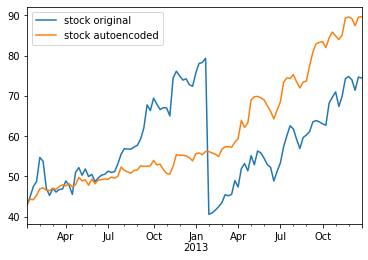

In [5]:
#first

which_stock = 1

# now decoded last price plot
stock_autoencoder = copy.deepcopy(reconstruct[:, which_stock])
stock_autoencoder[0] = 0
stock_autoencoder = stock_autoencoder.cumsum()
stock_autoencoder += (stock['calibrate']['lp'].iloc[0, which_stock])

## plot for comparison
pd.Series(stock['calibrate']['lp'].iloc[:, which_stock].as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='stock original', legend=True)
pd.Series(stock_autoencoder, index=pd.date_range(start='01/06/2012', periods = 104,freq='W')).plot(label='stock autoencoded', legend=True)

C:\Users\user\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


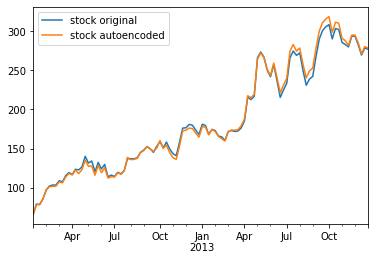

In [6]:
#fourth

which_stock = 4

# now decoded last price plot
stock_autoencoder = copy.deepcopy(reconstruct[:, which_stock])
stock_autoencoder[0] = 0
stock_autoencoder = stock_autoencoder.cumsum()
stock_autoencoder += (stock['calibrate']['lp'].iloc[0, which_stock])

## plot for comparison
pd.Series(stock['calibrate']['lp'].iloc[:, which_stock].as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='stock original', legend=True)
pd.Series(stock_autoencoder, index=pd.date_range(start='01/06/2012', periods = 104,freq='W')).plot(label='stock autoencoded', legend=True)

# Phase 2: Calibrating

In [7]:
ibb_predict = defaultdict(defaultdict)
total_2_norm_diff = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)

for non_communal in [15, 35, 55]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index
    
    
    # connect all layers
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
    
    
    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x = stock['calibrate']['percentage'].iloc[:, stock_index]
    y = ibb['calibrate']['percentage']
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    deep_learner.fit(x, y, shuffle=False, epochs=500, batch_size = 10)    # fit the model
    deep_learner.save('model/retrack_s' + str(s) + '.h5') # for validation phase use
    
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    ibb_predict['calibrate'][s] = ibb['calibrate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['calibrate'][s] = np.linalg.norm((ibb_predict['calibrate'][s] - ibb['calibrate']['lp']))

Epoch 1/500
104/104 [==============================] - 0s 2ms/step - loss: 5.3510
Epoch 2/500
104/104 [==============================] - 0s 163us/step - loss: 2.8817
Epoch 3/500
104/104 [==============================] - 0s 153us/step - loss: 2.1421
Epoch 4/500
104/104 [==============================] - 0s 153us/step - loss: 1.7040
Epoch 5/500
104/104 [==============================] - 0s 173us/step - loss: 1.4198
Epoch 6/500
104/104 [==============================] - 0s 153us/step - loss: 1.2230
Epoch 7/500
104/104 [==============================] - 0s 163us/step - loss: 1.0753
Epoch 8/500
104/104 [==============================] - 0s 153us/step - loss: 0.9647
Epoch 9/500
104/104 [==============================] - 0s 153us/step - loss: 0.8818
Epoch 10/500
104/104 [==============================] - 0s 153us/step - loss: 0.8172
Epoch 11/500
104/104 [==============================] - 0s 153us/step - loss: 0.7645
Epoch 12/500
104/104 [==============================] - 0s 163us/step - loss

104/104 [==============================] - 0s 144us/step - loss: 0.2622
Epoch 193/500
104/104 [==============================] - 0s 144us/step - loss: 0.2620
Epoch 194/500
104/104 [==============================] - 0s 125us/step - loss: 0.2612
Epoch 195/500
104/104 [==============================] - 0s 125us/step - loss: 0.2612
Epoch 196/500
104/104 [==============================] - 0s 134us/step - loss: 0.2606
Epoch 197/500
104/104 [==============================] - 0s 163us/step - loss: 0.2608
Epoch 198/500
104/104 [==============================] - 0s 144us/step - loss: 0.2598
Epoch 199/500
104/104 [==============================] - 0s 134us/step - loss: 0.2601
Epoch 200/500
104/104 [==============================] - 0s 144us/step - loss: 0.2596
Epoch 201/500
104/104 [==============================] - 0s 144us/step - loss: 0.2592
Epoch 202/500
104/104 [==============================] - 0s 134us/step - loss: 0.2592
Epoch 203/500
104/104 [==============================] - 0s 134us/st

104/104 [==============================] - 0s 240us/step - loss: 0.2311
Epoch 383/500
104/104 [==============================] - 0s 144us/step - loss: 0.2315
Epoch 384/500
104/104 [==============================] - 0s 153us/step - loss: 0.2308
Epoch 385/500
104/104 [==============================] - 0s 259us/step - loss: 0.2310
Epoch 386/500
104/104 [==============================] - 0s 144us/step - loss: 0.2306
Epoch 387/500
104/104 [==============================] - 0s 163us/step - loss: 0.2311
Epoch 388/500
104/104 [==============================] - 0s 173us/step - loss: 0.2307
Epoch 389/500
104/104 [==============================] - 0s 173us/step - loss: 0.2307
Epoch 390/500
104/104 [==============================] - 0s 153us/step - loss: 0.2304
Epoch 391/500
104/104 [==============================] - 0s 173us/step - loss: 0.2305
Epoch 392/500
104/104 [==============================] - 0s 153us/step - loss: 0.2305
Epoch 393/500
104/104 [==============================] - 0s 153us/st

104/104 [==============================] - 0s 125us/step - loss: 0.2221
Epoch 478/500
104/104 [==============================] - 0s 125us/step - loss: 0.2217
Epoch 479/500
104/104 [==============================] - 0s 96us/step - loss: 0.2215
Epoch 480/500
104/104 [==============================] - 0s 105us/step - loss: 0.2218
Epoch 481/500
104/104 [==============================] - 0s 173us/step - loss: 0.2217
Epoch 482/500
104/104 [==============================] - 0s 96us/step - loss: 0.2210
Epoch 483/500
104/104 [==============================] - 0s 125us/step - loss: 0.2206
Epoch 484/500
104/104 [==============================] - 0s 134us/step - loss: 0.2207
Epoch 485/500
104/104 [==============================] - 0s 115us/step - loss: 0.2204
Epoch 486/500
104/104 [==============================] - 0s 115us/step - loss: 0.2203
Epoch 487/500
104/104 [==============================] - 0s 125us/step - loss: 0.2199
Epoch 488/500
104/104 [==============================] - 0s 115us/step

104/104 [==============================] - 0s 144us/step - loss: 0.1606
Epoch 169/500
104/104 [==============================] - 0s 153us/step - loss: 0.1592
Epoch 170/500
104/104 [==============================] - 0s 153us/step - loss: 0.1598
Epoch 171/500
104/104 [==============================] - 0s 163us/step - loss: 0.1591
Epoch 172/500
104/104 [==============================] - 0s 201us/step - loss: 0.1578
Epoch 173/500
104/104 [==============================] - 0s 144us/step - loss: 0.1584
Epoch 174/500
104/104 [==============================] - 0s 134us/step - loss: 0.1579
Epoch 175/500
104/104 [==============================] - 0s 125us/step - loss: 0.1567
Epoch 176/500
104/104 [==============================] - 0s 125us/step - loss: 0.1571
Epoch 177/500
104/104 [==============================] - 0s 96us/step - loss: 0.1567
Epoch 178/500
104/104 [==============================] - 0s 115us/step - loss: 0.1555
Epoch 179/500
104/104 [==============================] - 0s 125us/ste

104/104 [==============================] - 0s 115us/step - loss: 0.1154
Epoch 359/500
104/104 [==============================] - 0s 115us/step - loss: 0.1160
Epoch 360/500
104/104 [==============================] - 0s 144us/step - loss: 0.1153
Epoch 361/500
104/104 [==============================] - 0s 115us/step - loss: 0.1151
Epoch 362/500
104/104 [==============================] - 0s 144us/step - loss: 0.1157
Epoch 363/500
104/104 [==============================] - 0s 173us/step - loss: 0.1151
Epoch 364/500
104/104 [==============================] - 0s 134us/step - loss: 0.1149
Epoch 365/500
104/104 [==============================] - 0s 115us/step - loss: 0.1147
Epoch 366/500
104/104 [==============================] - 0s 105us/step - loss: 0.1155
Epoch 367/500
104/104 [==============================] - 0s 115us/step - loss: 0.1148
Epoch 368/500
104/104 [==============================] - 0s 134us/step - loss: 0.1146
Epoch 369/500
104/104 [==============================] - 0s 144us/st

104/104 [==============================] - 0s 144us/step - loss: 0.1539
Epoch 48/500
104/104 [==============================] - 0s 134us/step - loss: 0.1522
Epoch 49/500
104/104 [==============================] - 0s 144us/step - loss: 0.1505
Epoch 50/500
104/104 [==============================] - 0s 115us/step - loss: 0.1488
Epoch 51/500
104/104 [==============================] - 0s 115us/step - loss: 0.1474
Epoch 52/500
104/104 [==============================] - 0s 115us/step - loss: 0.1458
Epoch 53/500
104/104 [==============================] - 0s 134us/step - loss: 0.1444
Epoch 54/500
104/104 [==============================] - 0s 115us/step - loss: 0.1429
Epoch 55/500
104/104 [==============================] - 0s 96us/step - loss: 0.1417
Epoch 56/500
104/104 [==============================] - 0s 115us/step - loss: 0.1403
Epoch 57/500
104/104 [==============================] - 0s 125us/step - loss: 0.1391
Epoch 58/500
104/104 [==============================] - 0s 144us/step - loss: 0

104/104 [==============================] - 0s 134us/step - loss: 0.0828
Epoch 238/500
104/104 [==============================] - 0s 115us/step - loss: 0.0826
Epoch 239/500
104/104 [==============================] - 0s 153us/step - loss: 0.0824
Epoch 240/500
104/104 [==============================] - 0s 115us/step - loss: 0.0823
Epoch 241/500
104/104 [==============================] - 0s 125us/step - loss: 0.0824
Epoch 242/500
104/104 [==============================] - 0s 153us/step - loss: 0.0821
Epoch 243/500
104/104 [==============================] - 0s 201us/step - loss: 0.0819
Epoch 244/500
104/104 [==============================] - 0s 192us/step - loss: 0.0819
Epoch 245/500
104/104 [==============================] - 0s 134us/step - loss: 0.0818
Epoch 246/500
104/104 [==============================] - 0s 144us/step - loss: 0.0816
Epoch 247/500
104/104 [==============================] - 0s 134us/step - loss: 0.0815
Epoch 248/500
104/104 [==============================] - 0s 134us/st

104/104 [==============================] - 0s 144us/step - loss: 0.0685
Epoch 427/500
104/104 [==============================] - 0s 153us/step - loss: 0.0684
Epoch 428/500
104/104 [==============================] - 0s 144us/step - loss: 0.0683
Epoch 429/500
104/104 [==============================] - 0s 182us/step - loss: 0.0684
Epoch 430/500
104/104 [==============================] - 0s 153us/step - loss: 0.0682
Epoch 431/500
104/104 [==============================] - 0s 144us/step - loss: 0.0682
Epoch 432/500
104/104 [==============================] - 0s 153us/step - loss: 0.0682
Epoch 433/500
104/104 [==============================] - 0s 144us/step - loss: 0.0681
Epoch 434/500
104/104 [==============================] - 0s 163us/step - loss: 0.0680
Epoch 435/500
104/104 [==============================] - 0s 201us/step - loss: 0.0681
Epoch 436/500
104/104 [==============================] - 0s 144us/step - loss: 0.0680
Epoch 437/500
104/104 [==============================] - 0s 163us/st

Now we check to see how similar these 3 portfolios perform as the original IBB Index does on training dates.

C:\Users\user\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


S25 2-norm difference:  22.838774
S45 2-norm difference:  10.082207
S65 2-norm difference:  2.3714294


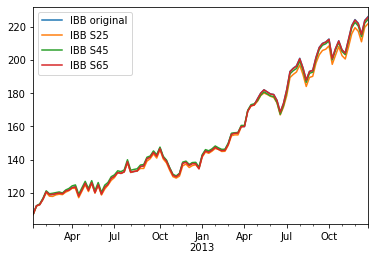

In [8]:
# plot results and 2-norm differences 
pd.Series(ibb['calibrate']['lp'].as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='IBB original', legend=True)

for s in [25, 45, 65]:
    pd.Series(ibb_predict['calibrate'][s], index=pd.date_range(start='01/06/2012', periods = 104,freq='W')).plot(label='IBB S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['calibrate'][s])    
    


# Phase 3: Validating

In [9]:
for non_communal in [15, 35, 55]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index
    
    # load our trained models
    deep_learner = load_model('model/retrack_s' + str(s) + '.h5')
    
    
    x = stock['validate']['percentage'].iloc[:, stock_index]
    x = dl_scaler[s].transform(x)  
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    ibb_predict['validate'][s] = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['validate'][s] = np.linalg.norm((ibb_predict['validate'][s] - ibb['validate']['lp']))

Again, we would check to visualise how similar these 3 portfolios perform as the original IBB Index does, but on test dates.

C:\Users\user\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


S25 2-norm difference:  1158.1785
S45 2-norm difference:  1126.5337
S65 2-norm difference:  493.75314


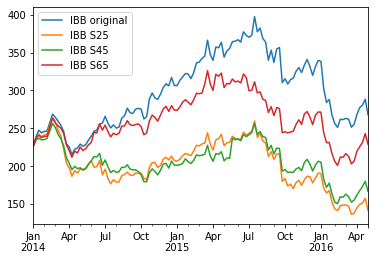

In [10]:
# plot results and 2-norm differences
pd.Series(ibb['validate']['lp'].as_matrix(), index=pd.date_range(start='01/03/2014', periods=122, freq='W')).plot(label='IBB original', legend=True) 

for s in [25, 45, 65]:
    pd.Series(ibb_predict['validate'][s], index=pd.date_range(start='01/03/2014', periods = 122,freq='W')).plot(label='IBB S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['validate'][s])  

# Phase 4: Verifying

- x-axis: 2-norm error  
- y-axis: # of stocks in the portfolios: 10, 11, 12, ..., 

Sir, We also created an Efficient Fronitier for the Modern Portfolio Theory by randomisinf 50,000 portfolios, but Sir, we feel that from our perspective, Efficient Deep Frontier has nothing to do with the one in Modern Portfolio Theory. This one just reflects the trade-off between more stocks in the portfolios and higher or lower MSE.

In [ ]:
error = []
for non_communal in range(5, 79, 1):  
    
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index


    # training
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
    
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x_train = stock['calibrate']['percentage'].iloc[:, stock_index]
    y_train = ibb['calibrate']['percentage']
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x_train)
    x_train = dl_scaler[s].transform(x_train)  
    
    deep_learner.fit(x_train, y_train, shuffle=False, epochs=500, batch_size = 10)    # fit the model


    # testing
    x_test = stock['validate']['percentage'].iloc[:, stock_index]
    y_test = ibb['validate']['percentage']

    x_test = dl_scaler[s].transform(x_test)  
    
    relative_percentage = copy.deepcopy(deep_learner.predict(x_test))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
    error.append(np.linalg.norm((predict_curve - ibb['validate']['lp'])))    

Text(0,0.5,'number of stocks in the portfolio')

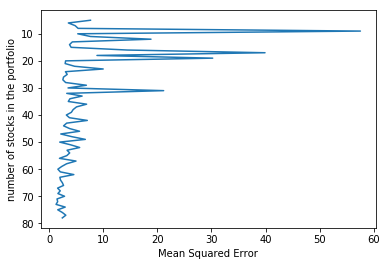

In [20]:
# Plotting Efficient Deep Frontier

mse = [e/len(ibb['validate']['lp']) for e in error] # mse = sum of 2 norm difference/ # of test dates
plt.gca().invert_yaxis()
plt.plot(mse, list(range(5,79,1)))
plt.xlabel('Mean Squared Error')
plt.ylabel('number of stocks in the portfolio') 